In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import PIL

from tqdm import tqdm_notebook

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#Images path
dataset_path = "./cats_and_dogs_filtered"

train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "validation")

In [3]:
#Load MobileNetV2


img_shape = (128, 128, 3)

base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights="imagenet")
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [4]:
#Freeze MobileNetV2
base_model.trainable = False

In [5]:
base_model.output

<tf.Tensor 'out_relu/Relu6:0' shape=(None, 4, 4, 1280) dtype=float32>

In [6]:
global_average_layer = GlobalAveragePooling2D()(base_model.output)

In [7]:
global_average_layer

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(None, 1280) dtype=float32>

In [8]:
prediction_layer = Dense(units=1, activation="sigmoid")(global_average_layer)

In [9]:
model = Model(inputs=base_model.input, outputs=prediction_layer)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

In [10]:
model.compile(optimizer=RMSprop(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
data_gen_train = ImageDataGenerator(rescale=1/255.0)
data_gen_valid = ImageDataGenerator(rescale=1/255.0)

In [12]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(128, 128), batch_size=128, class_mode="binary")
valid_generator = data_gen_train.flow_from_directory(validation_dir, target_size=(128, 128), batch_size=128, class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10
16/16 [==============================] - 9s 553ms/step - loss: 0.6624 - accuracy: 0.6080 - val_loss: 0.6015 - val_accuracy: 0.6930
Epoch 2/10
16/16 [==============================] - 9s 537ms/step - loss: 0.5616 - accuracy: 0.7115 - val_loss: 0.5249 - val_accuracy: 0.7590
Epoch 3/10
16/16 [==============================] - 8s 527ms/step - loss: 0.4917 - accuracy: 0.7770 - val_loss: 0.4615 - val_accuracy: 0.8090
Epoch 4/10
16/16 [==============================] - 8s 516ms/step - loss: 0.4337 - accuracy: 0.8265 - val_loss: 0.4082 - val_accuracy: 0.8440
Epoch 5/10
16/16 [==============================] - 8s 514ms/step - loss: 0.3848 - accuracy: 0.8525 - val_loss: 0.3639 - val_accuracy: 0.8760
Epoch 6/10
16/16 [==============================] - 8s 518ms/step - loss: 0.3438 - accuracy: 0.8790 - val_loss: 0.3260 - val_accuracy: 0.8910
Epoch 7/10
16/16 [==============================] - 8s 518ms/step - loss: 0.3093 - accuracy: 0.8925 - val_loss: 0.2943 - val_accuracy: 0.9000
Epoch 

In [17]:
valid_loss, valid_accuracy = model.evaluate(valid_generator)
print("Loss: ", valid_loss)
print("Accuracy: ", valid_accuracy)

8/8 [==============================] - 2s 303ms/step - loss: 0.2276 - accuracy: 0.9260
Loss:  0.22761161625385284
Accuracy:  0.9259999990463257


## Fine Tuning

In [19]:
base_model.trainable = True
len(base_model.layers)

155

In [20]:
fine_tuning_at = 100

In [22]:
for layer in base_model.layers[:fine_tuning_at]:
    layer.trainable = False

In [24]:
model.compile(optimizer=RMSprop(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [26]:
model.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10
16/16 [==============================] - 12s 780ms/step - loss: 0.2720 - accuracy: 0.9040 - val_loss: 0.9098 - val_accuracy: 0.9110
Epoch 2/10
16/16 [==============================] - 12s 740ms/step - loss: 0.0563 - accuracy: 0.9795 - val_loss: 0.4412 - val_accuracy: 0.9320
Epoch 3/10
16/16 [==============================] - 12s 736ms/step - loss: 0.0631 - accuracy: 0.9740 - val_loss: 0.5948 - val_accuracy: 0.9430
Epoch 4/10
16/16 [==============================] - 12s 740ms/step - loss: 0.0197 - accuracy: 0.9940 - val_loss: 1.9431 - val_accuracy: 0.8590
Epoch 5/10
16/16 [==============================] - 12s 741ms/step - loss: 0.0568 - accuracy: 0.9805 - val_loss: 0.4381 - val_accuracy: 0.9580
Epoch 6/10
16/16 [==============================] - 12s 741ms/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 3.1460 - val_accuracy: 0.8220
Epoch 7/10
16/16 [==============================] - 12s 750ms/step - loss: 0.0391 - accuracy: 0.9890 - val_loss: 0.7601 - val_accuracy: 0.9440

In [28]:
valid_loss, valid_accuracy = model.evaluate(valid_generator)
print("Loss: ", valid_loss)
print("Accuracy: ", valid_accuracy)

8/8 [==============================] - 2s 297ms/step - loss: 0.7344 - accuracy: 0.9230
Loss:  0.7343553304672241
Accuracy:  0.9229999780654907


In [27]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

In [59]:
image = tf.keras.preprocessing.image.load_img("anitta.jpg", target_size=(128, 128))

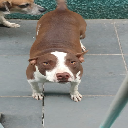

In [60]:
image

In [61]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)/255.

In [62]:
X_test = np.array([input_arr])

In [63]:
#0 -> cat
#1 -> dog

In [64]:
result = model.predict(X_test)

In [65]:
result[0][0]

0.99999523

In [66]:
model.save("models/1")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/1/assets


In [ ]:
# %%bash --bg 
# nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${model_dir}" >server.log 2>&1